# Simpsons Classifier


## Images with different sizes: understanding _Spatial Pyramid Pooling_

If the neural network has a fixed size as input images we'll have to deal with it. 

So the possible solutions will be:

* Crop: problem, there is information that gets lost.
* Warp/Resize: problem, the image patterns change and we lose accuracy.
* Padding: problem, the model might be biased to images that contain such a padded border.
* Combination of previous.

Spatial Pyramid Pooling tries to resolve it. Indeed it should improve the efficiency.

Paper: https://arxiv.org/abs/1406.4729

## Defining Datasets

In [1]:
#Import libraries
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
from random import shuffle

In [2]:
#Initial data inside simpsons.tar.gz
info = pd.read_csv('./the-simpsons-characters-dataset/number_pic_char.csv')
print(info)

    Unnamed: 0                      name  total  train  test  bounding_box
0            0             Homer Simpson   2246   1909   337           612
1            1              Ned Flanders   1454   1236   218           595
2            2               Moe Szyslak   1452   1234   218           215
3            3              Lisa Simpson   1354   1151   203           562
4            4              Bart Simpson   1342   1141   201           554
5            5             Marge Simpson   1291   1097   194           557
6            6          Krusty The Clown   1206   1025   181           226
7            7         Principal Skinner   1194   1015   179           506
8            8  Charles Montgomery Burns   1193   1014   179           650
9            9       Milhouse Van Houten   1079    917   162           210
10          10              Chief Wiggum    986    838   148           209
11          11    Abraham Grampa Simpson    913    776   137           595
12          12           

In [3]:
def get_character_directories(path):
    character_directories = os.listdir(path)
    if '.DS_Store' in character_directories: character_directories.remove('.DS_Store')
    return character_directories

def get_images_from_directory(path):
    image_files = os.listdir(path)
    if '.DS_Store' in image_files: image_files.remove('.DS_Store')
    return image_files

In [4]:
#root pats
train_root_path = "./the-simpsons-characters-dataset-TINY/simpsons_dataset"
test_root_path = "./the-simpsons-characters-dataset-TINY/kaggle_simpson_testset"

#train directories
character_directories = get_character_directories(train_root_path)

In [5]:
def test_paths():
    #configure train dataset
    print("Train: {}".format(character_directories[:5]))

    #images from one train directory
    character_path = train_root_path + "/" + character_directories[1]
    train_image_names = get_images_from_directory(character_path)
    print("Images of {}: {}".format(character_directories[1], train_image_names[:5]))


    #configure test dataset
    test_image_names = get_images_from_directory(test_root_path)
    print("\nTest: {}".format(test_image_names[:5]))

test_paths()

Train: ['maggie_simpson', 'charles_montgomery_burns', 'patty_bouvier', 'ralph_wiggum', 'chief_wiggum']
Images of charles_montgomery_burns: ['pic_0982.jpg', 'pic_0028.jpg', 'pic_0996.jpg', 'pic_0766.jpg', 'pic_0000.jpg']

Test: ['principal_skinner_34.jpg', 'apu_nahasapeemapetilon_28.jpg', 'abraham_grampa_simpson_41.jpg', 'principal_skinner_20.jpg', 'apu_nahasapeemapetilon_14.jpg']


### Showing Training and Test Samples

In [32]:
def plot_image(image):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Label:charles_montgomery_burns, Image:1, Shape:(26, 34, 3)


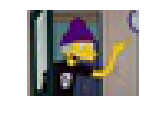

In [57]:
def show_train_image(character_directory, idx):
    directory = os.path.join(train_root_path, character_directory)
    sample_file = get_images_from_directory(directory)[idx]
    path_file = os.path.join(directory, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format(character_directory, idx, sample_image.shape))
    plot_image(sample_image)
    
idx = random.randint(0, 10)
show_train_image(character_directories[idx], idx)

Label:principal_skinner, Image:3, Shape:(37, 52, 3)


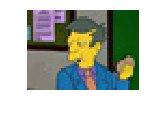

In [58]:
def show_test_image(idx):
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
    plot_image(sample_image)

idx = random.randint(0, 10)
show_test_image(idx)

### Training Images

In [59]:
'''
input 'different_characters' will define the number of different Simpson
characters the generator is going to return
'''
#Create the batch generator
def batch_generator_training_images(batch_size, different_characters, verbose=False):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    characters = characters.map(lambda x: x.replace(" ", "_").lower()).tolist()

    path_name_list = list()
    for i in range(0, different_characters):
        directory = os.path.join(train_root_path, characters[i])
        path_name_list += list(map( lambda x: (os.path.join(directory, x), characters[i]), 
                                    get_images_from_directory(directory)))

    #shuffle all the images
    shuffle(path_name_list)
    
    #getting a number of complete chunks according to the batch size
    number_complete_chunks = len(path_name_list)//batch_size
    num_images_in_all_chunks = number_complete_chunks * batch_size
        
    for b in range(0, num_images_in_all_chunks, batch_size):
        if verbose:
            print("init: {}, end:{}".format(b, b+batch_size))
            
        #transform the path to image to image array
        #yield list(map( lambda x: (imread(x[0]), x[1]), 
        #                path_name_list[b:b + batch_size]))
        
        yield (list(map( lambda x: imread(x[0]), path_name_list[b:b + batch_size])), 
               list(map( lambda x: x[1], path_name_list[b:b + batch_size])) )
        
        
        
        
        #TO REMOVE: LIMIT THE FINAL NUMBER OF IMAGES
        if (b > 100):
            break

init: 0, end:32
charles_montgomery_burns


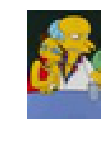

In [60]:
#testing how to show an image from generator
def testing_generator_1():
    for batch in batch_generator_training_images(32, 10, True):
        for img, name in zip(*batch):
            print(name)
            plot_image(img)
            break
        pass
        break
        
testing_generator_1()

In [61]:
#testing the generator
def testing_generator_2():
    group = {}

    for batch in batch_generator_training_images(32, 10, True):
        for img, name in zip(*batch):
            if not img.shape in group:
                group[img.shape] = []
            group[img.shape].append(img)
        pass
        break

    for key, lists in group.items():
        print("shape{} count:{}".format(key, len(lists)))


testing_generator_2()

init: 0, end:32
shape(42, 29, 3) count:3
shape(43, 29, 3) count:6
shape(35, 31, 3) count:1
shape(26, 38, 3) count:1
shape(38, 26, 3) count:1
shape(40, 26, 3) count:1
shape(43, 58, 3) count:5
shape(48, 32, 3) count:6
shape(43, 27, 3) count:1
shape(48, 64, 3) count:4
shape(42, 58, 3) count:2
shape(35, 62, 3) count:1


## Keras + SPP Module

Keras doesn't support currently the SSP layer but thanks to [yhenon](https://github.com/yhenon) there's a module which is integrated into keras. [Code is here](https://github.com/yhenon/keras-spp)

In [62]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, Convolution2D, Activation, MaxPooling2D, Dense
from spp.SpatialPyramidPooling import SpatialPyramidPooling

Using TensorFlow backend.


In [85]:
'''
Build a model with a typical network architecture
'''
def build_model(num_channels = 3, num_classes = 10):
    model = Sequential()

    #Note: leave the image size as None to allow multiple image sizes
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(None, None, num_channels)))
    model.add(Activation('relu'))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(SpatialPyramidPooling([1, 2, 4]))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, None, None, 32)    896       
_________________________________________________________________
activation_21 (Activation)   (None, None, None, 32)    0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
activation_22 (Activation)   (None, None, None, 32)    0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 64)    18496     
_________________________________________________________________
activation_23 (Activation)   (None, None, None, 64)    0         
__________

In [64]:
#TESTING
# train on images with different sizes
def model_tried_out(num_channels, num_classes, batch_size):
    model = build_model(num_channels, num_classes)
    #size 1
    model.fit(np.random.rand(batch_size, 8, 9, num_channels), 
              np.random.rand(batch_size, num_classes),
              epochs=1)
    #size 2
    model.fit(np.random.rand(batch_size, 20, 13, num_channels), 
              np.random.rand(batch_size, num_classes),
              epochs=1)
    
model_tried_out(2, 2, 16)

Epoch 1/1
16/16 [==============================] - 0s 29ms/step - loss: 1.1780e-07
Epoch 1/1
16/16 [==============================] - 0s 3ms/step - loss: 1.2410e-07


In [65]:
#global variables
batch_size = 64
num_channels = 3
num_classes = 10 #different number of Simpons characters

In [95]:
#one hot encoder (proof of concept)
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

def customize_onehot_encoder(num_classes):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    names = characters[:num_classes].map(lambda x: x.replace(" ", "_").lower()).tolist()

    print("Character classes: {}".format(names))
    lb.fit(names)

Character classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson']
moe_szyslak
[0 0 1 0]


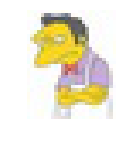

Training shape:(32, 26, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 15ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 18ms/step - loss: 16.1181
moe_szyslak
[0 0 1 0]


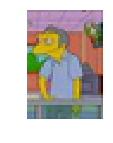

Training shape:(46, 32, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 31ms/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 35ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 27ms/step - loss: 16.1181
ned_flanders
[0 0 0 1]


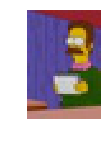

Training shape:(43, 29, 3) with 11 images
Epoch 1/3
11/11 [==============================] - 0s 13ms/step - loss: 6.8689
Epoch 2/3
11/11 [==============================] - 0s 12ms/step - loss: 7.3282
Epoch 3/3
11/11 [==============================] - 0s 12ms/step - loss: 7.3265
ned_flanders
[0 0 0 1]


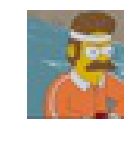

Training shape:(35, 31, 3) with 9 images
Epoch 1/3
9/9 [==============================] - 0s 10ms/step - loss: 8.6599
Epoch 2/3
9/9 [==============================] - 0s 11ms/step - loss: 12.5363
Epoch 3/3
9/9 [==============================] - 0s 11ms/step - loss: 12.5363
lisa_simpson
[0 1 0 0]


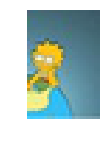

Training shape:(39, 26, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 19ms/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 19ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 17ms/step - loss: 16.1181
homer_simpson
[1 0 0 0]


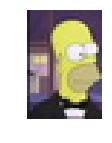

Training shape:(38, 26, 3) with 2 images
Epoch 1/3
2/2 [==============================] - 0s 16ms/step - loss: 1.1921e-07
Epoch 2/3
2/2 [==============================] - 0s 17ms/step - loss: 1.1921e-07
Epoch 3/3
2/2 [==============================] - 0s 19ms/step - loss: 1.1921e-07
lisa_simpson
[0 1 0 0]


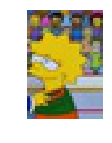

Training shape:(42, 29, 3) with 2 images
Epoch 1/3
2/2 [==============================] - 0s 25ms/step - loss: 8.0590
Epoch 2/3
2/2 [==============================] - 0s 21ms/step - loss: 8.0590
Epoch 3/3
2/2 [==============================] - 0s 20ms/step - loss: 8.0590
homer_simpson
[1 0 0 0]


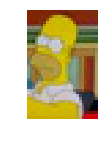

Training shape:(40, 26, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 19ms/step - loss: 1.1921e-07
Epoch 2/3
1/1 [==============================] - 0s 22ms/step - loss: 1.1921e-07
Epoch 3/3
1/1 [==============================] - 0s 24ms/step - loss: 1.1921e-07
homer_simpson
[1 0 0 0]


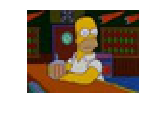

Training shape:(43, 58, 3) with 6 images
Epoch 1/3
6/6 [==============================] - 0s 33ms/step - loss: 5.3727
Epoch 2/3
6/6 [==============================] - 0s 28ms/step - loss: 5.3727
Epoch 3/3
6/6 [==============================] - 0s 26ms/step - loss: 5.3727
moe_szyslak
[0 0 1 0]


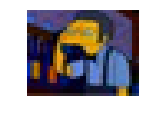

Training shape:(26, 34, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 19ms/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 17ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 19ms/step - loss: 16.1181
lisa_simpson
[0 1 0 0]


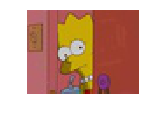

Training shape:(48, 64, 3) with 8 images
Epoch 1/3
8/8 [==============================] - 0s 49ms/step - loss: 8.0590
Epoch 2/3
8/8 [==============================] - 0s 53ms/step - loss: 8.0590
Epoch 3/3
8/8 [==============================] - 0s 34ms/step - loss: 8.0590
lisa_simpson
[0 1 0 0]


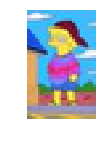

Training shape:(41, 26, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 31ms/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 21ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 22ms/step - loss: 16.1181
homer_simpson
[1 0 0 0]


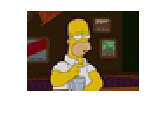

Training shape:(46, 64, 3) with 2 images
Epoch 1/3
2/2 [==============================] - 0s 60ms/step - loss: 8.0590
Epoch 2/3
2/2 [==============================] - 0s 37ms/step - loss: 8.0590
Epoch 3/3
2/2 [==============================] - 0s 38ms/step - loss: 8.0590
lisa_simpson
[0 1 0 0]


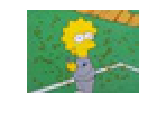

Training shape:(37, 50, 3) with 4 images
Epoch 1/3
4/4 [==============================] - 0s 22ms/step - loss: 12.0886
Epoch 2/3
4/4 [==============================] - 0s 21ms/step - loss: 12.0886
Epoch 3/3
4/4 [==============================] - 0s 22ms/step - loss: 12.0886
lisa_simpson
[0 1 0 0]


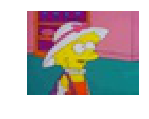

Training shape:(40, 53, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 49ms/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 51ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 47ms/step - loss: 16.1181
homer_simpson
[1 0 0 0]


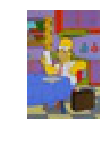

Training shape:(48, 32, 3) with 6 images
Epoch 1/3
6/6 [==============================] - 0s 18ms/step - loss: 8.0590
Epoch 2/3
6/6 [==============================] - 0s 16ms/step - loss: 8.0590
Epoch 3/3
6/6 [==============================] - 0s 17ms/step - loss: 8.0590
lisa_simpson
[0 1 0 0]


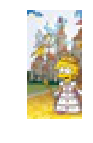

Training shape:(52, 26, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 26ms/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 27ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 23ms/step - loss: 16.1181
homer_simpson
[1 0 0 0]


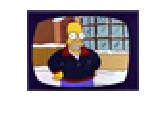

Training shape:(42, 58, 3) with 2 images
Epoch 1/3
2/2 [==============================] - 0s 66ms/step - loss: 1.1921e-07
Epoch 2/3
2/2 [==============================] - 0s 47ms/step - loss: 1.1921e-07
Epoch 3/3
2/2 [==============================] - 0s 65ms/step - loss: 1.1921e-07
homer_simpson
[1 0 0 0]


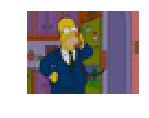

Training shape:(38, 51, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 30ms/step - loss: 1.1921e-07
Epoch 2/3
1/1 [==============================] - 0s 39ms/step - loss: 1.1921e-07
Epoch 3/3
1/1 [==============================] - 0s 37ms/step - loss: 1.1921e-07
moe_szyslak
[0 0 1 0]


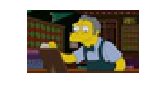

Training shape:(35, 62, 3) with 2 images
Epoch 1/3
2/2 [==============================] - 0s 49ms/step - loss: 8.0590
Epoch 2/3
2/2 [==============================] - 0s 75ms/step - loss: 8.0590
Epoch 3/3
2/2 [==============================] - 0s 54ms/step - loss: 8.0590
moe_szyslak
[0 0 1 0]


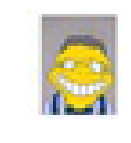

Training shape:(30, 26, 3) with 1 images
Epoch 1/3
1/1 [==============================] - 0s 24ms/step - loss: 16.1181
Epoch 2/3
1/1 [==============================] - 0s 27ms/step - loss: 16.1181
Epoch 3/3
1/1 [==============================] - 0s 22ms/step - loss: 16.1181


In [100]:
def test1():
    num_classes = 4
    customize_onehot_encoder(num_classes)
    model = build_model(num_channels, num_classes)
    cnt = 0
    
    '''
    The batch generator returns a tuple of two lists!!! (list_images, list_names)
    '''
    for batch in batch_generator_training_images(batch_size, num_classes):
        
        #group by shape
        grouped = {}
        for image, name in zip(*batch):
            if not image.shape in grouped:
                grouped[image.shape] = []
            grouped[image.shape].append((image, name))        
        
        #training images which are grouped by shape at the same time
        for shape, tuple_imagesList_namesList in grouped.items():
            imagesList, namesList = zip(*tuple_imagesList_namesList)
            
            #casting
            images = np.array(imagesList)
            #onehot encoding names
            target_names = np.array(lb.transform(namesList))
            print(namesList[0])
            print(lb.transform(namesList)[0])
            plot_image(imagesList[0])
            
            print("Training shape:{} with {} images".format(shape, len(images)))
            
            model.fit(images, target_names, epochs=3)
        
        #TO REMOVE
        if cnt >= 0:
            break
        cnt+=1
            
    return model

model1 = test1()

Label: sideshow_bob
PREDICTION: homer_simpson


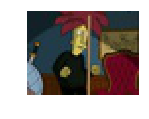

In [102]:
def eyeball_test_model(model):
    idx = random.randint(0, 100)
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label: {}".format('_'.join(sample_name)))
    
    #prediction
    pred = model.predict(sample_image[np.newaxis,:])
    print("PREDICTION: {}".format(lb.inverse_transform(pred)[0]))
 
    #showing the image
    plot_image(sample_image)

eyeball_test_model(model1)